<a href="https://colab.research.google.com/github/andrewLiu1028/HW1_seed_pred/blob/main/MLV_Lab_HW_202409.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

植物幼苗分類競賽

* 競賽目標:從圖像確定幼苗的物種
* 時間:2017年11月23日開始,2018年3月13日結束
* 背景:能有效區分雜草和作物幼苗可提高作物產量和環境管理數據集包含約960株獨特植物,屬於12個物種,處於不同生長階段。資料來自奧胡斯大學信號處理小組與南丹麥大學的合作
* **方法：套用一個 ResNet50 並替換掉最後一層 linear layer**
* 評估方式:
  * 畫出 training/validation loss curve
    (推薦使用 matplotlib)
  * 畫出 confusion matrix (validation set)
  * 附上 submission 結果

  * Kaggle 原來的要求:
    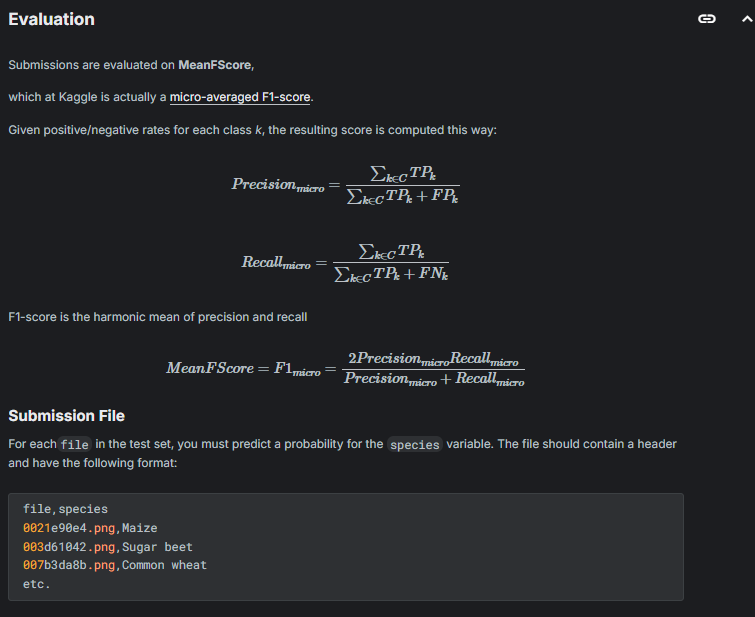
* 將 GitHub 連結貼在 Discord 的 [課業討論區]



In [1]:
# 掛載 Google Drive 到 Colab
from google.colab import drive
drive.mount('/content/drive')
# 切換到指定的工作目錄
import os
os.chdir('/content/drive/MyDrive/Colab/MLB_HW1')
# 顯示目前的工作目錄
!pwd
# 列出當前目錄下的所有檔案和資料夾
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/MLB_HW1
'MLV Lab HW_202409.ipynb'	      predictions.csv	      test
 plant-seedlings-classification.zip   sample_submission.csv   train


In [2]:
# 安裝 Kaggle 套件
!pip install kaggle

# 設定 Kaggle 憑證文件的路徑
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab/.kaggle"

# 下載 Kaggle 競賽 "Plant Seedlings Classification" 的數據集到指定目錄
!kaggle competitions download -c plant-seedlings-classification -p /content/drive/MyDrive/Colab/MLB_HW1

# 解壓縮
!unzip plant-seedlings-classification.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      
  inflating: test/b4f7c9214.p

In [3]:
# 顯示目前的工作目錄
!pwd
# 列出當前目錄下的所有檔案和資料夾
!ls

/content/drive/MyDrive/Colab/MLB_HW1
'MLV Lab HW_202409.ipynb'	      predictions.csv	      test
 plant-seedlings-classification.zip   sample_submission.csv   train


開始分析作業

In [4]:
# import 需要的套件
import torch
import torchvision
from torchvision import transforms, datasets #圖片預處理動作
from torch.utils.data import DataLoader, random_split, Subset, Dataset #載入數據，分割數據
from torchvision.datasets import ImageFolder #用於從目錄中加載圖片數據並自動標籤
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim as optim
import os
import pandas as pd
from PIL import Image
import random

總類別數: 12
總圖片數: 4750


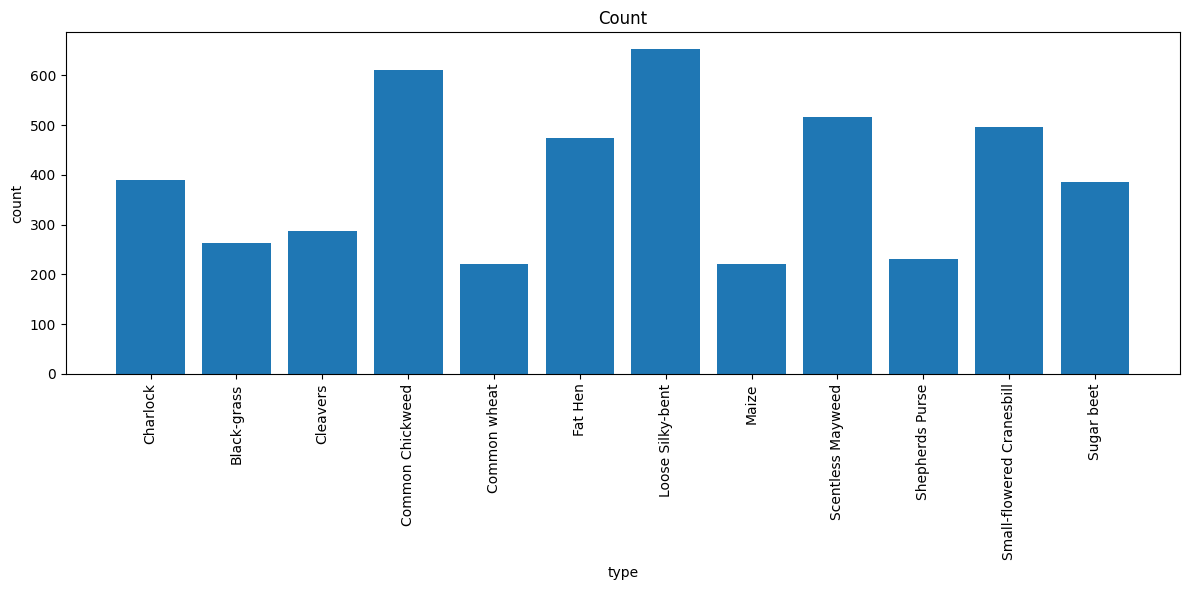

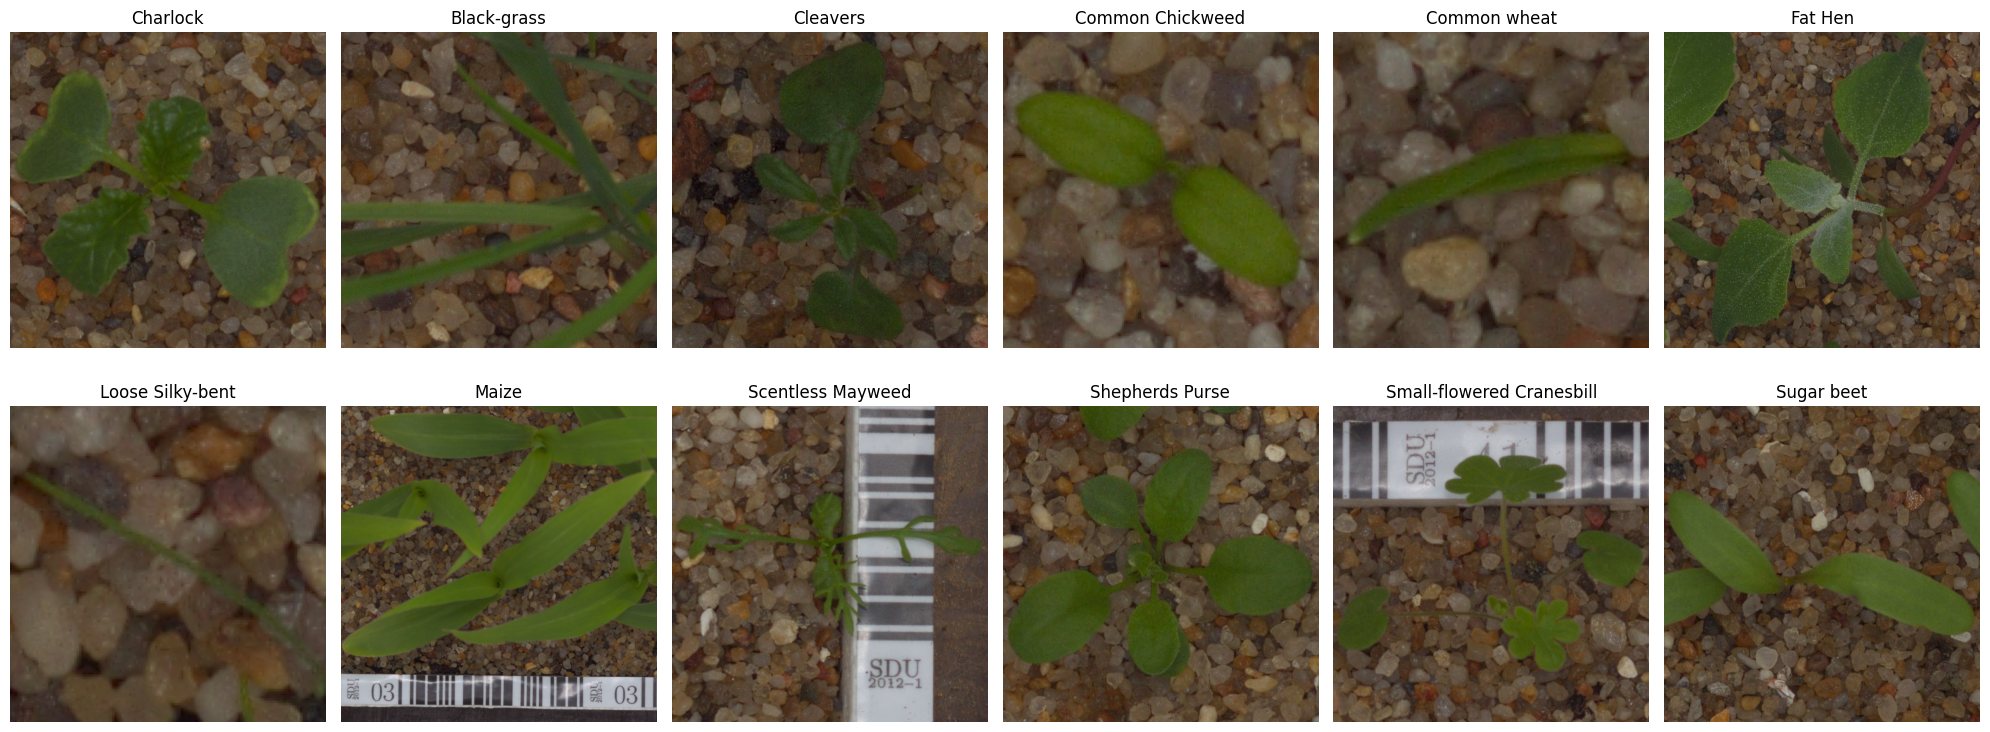

In [25]:
#基本繪圖

# 設置隨機種子以確保結果可重現
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# 定義數據目錄
data_dir = '/content/drive/MyDrive/Colab/MLB_HW1/train'

def analyze_dataset(data_dir):
    classes = os.listdir(data_dir)
    class_sizes = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

    print(f"總類別數: {len(classes)}")
    print(f"總圖片數: {sum(class_sizes)}")

    plt.figure(figsize=(12, 6))
    plt.bar(classes, class_sizes)
    plt.title('Count')
    plt.xlabel('type')
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 顯示每個類別的一個樣本圖片
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))
    for i, cls in enumerate(classes):
        img_path = os.path.join(data_dir, cls, random.choice(os.listdir(os.path.join(data_dir, cls))))
        img = Image.open(img_path)
        ax = axes[i // 6, i % 6]
        ax.imshow(img)
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

analyze_dataset(data_dir)

In [12]:
# 定義訓練數據轉換（包含數據增強）
train_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224)
    ]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定義驗證數據轉換（基本預處理，無數據增強）
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_and_split_data(data_dir, train_transform, val_transform, train_ratio=0.8, batch_size=32):
    # 加載完整數據集（初始不應用轉換）
    full_dataset = datasets.ImageFolder(data_dir)
    class_names = full_dataset.classes

    # 分割數據集
    train_size = int(train_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indices, val_indices = random_split(
        range(len(full_dataset)),
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # 創建訓練和驗證數據集，分別應用轉換
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # 創建數據加載器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, class_names

# 使用示例
if __name__ == "__main__":
    data_dir = '/content/drive/MyDrive/Colab/MLB_HW1/train'
    train_loader, val_loader, class_names = load_and_split_data(data_dir, train_transform, val_transform)

    print(f"Number of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")

    # 檢查訓練數據
    for images, labels in train_loader:
        print(f"Training batch shape: {images.shape}")
        print(f"Training labels shape: {labels.shape}")
        break

    # 檢查驗證數據
    for images, labels in val_loader:
        print(f"Validation batch shape: {images.shape}")
        print(f"Validation labels shape: {labels.shape}")
        break

Number of classes: 12
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Number of training batches: 119
Number of validation batches: 30
Training batch shape: torch.Size([32, 3, 224, 224])
Training labels shape: torch.Size([32])
Validation batch shape: torch.Size([32, 3, 224, 224])
Validation labels shape: torch.Size([32])


In [17]:
# 載入 ResNet50 預訓練模型
model = torchvision.models.resnet50(pretrained=True)
# 凍結預訓練模型的參數
for param in model.parameters():
    param.requires_grad = False

# 修改最後一層 fully-connected層，使其適應新的分類數量
num_classes = len(class_names)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# 移動模型到可用的設備 (GPU 或 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 只優化修改過的 fully-connected 層
optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)

#criterion
criterion = torch.nn.CrossEntropyLoss()

In [18]:
if torch.cuda.is_available():
    print("GPU 可用")
    print(f"GPU 型號: {torch.cuda.get_device_name(0)}")
else:
    print("GPU 不可用。當前使用 CPU。")

GPU 可用
GPU 型號: NVIDIA A100-SXM4-40GB


In [19]:
from tqdm.auto import tqdm

# 訓練
num_epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    running_loss = 0.0

    # 訓練循環
    train_pbar = tqdm(train_loader, leave=False, desc=f"Train Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0

    # 驗證循環
    val_pbar = tqdm(val_loader, leave=False, desc=f"Val Epoch {epoch+1}/{num_epochs}")
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch 1/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 1/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 1.4901, Val Loss: 0.8270


Train Epoch 2/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 2/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 0.8038, Val Loss: 0.7133


Train Epoch 3/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 3/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 0.6936, Val Loss: 0.6993


Train Epoch 4/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 4/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 0.6167, Val Loss: 0.6940


Train Epoch 5/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 5/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 0.5827, Val Loss: 0.7647


Train Epoch 6/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 6/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 0.5555, Val Loss: 0.6005


Train Epoch 7/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 7/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 0.4940, Val Loss: 0.5945


Train Epoch 8/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 8/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 0.4818, Val Loss: 0.5993


Train Epoch 9/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 9/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 0.4359, Val Loss: 0.6031


Train Epoch 10/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 10/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 0.4269, Val Loss: 0.6138


Train Epoch 11/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 11/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/30, Train Loss: 0.3920, Val Loss: 0.5689


Train Epoch 12/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 12/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 0.3749, Val Loss: 0.5271


Train Epoch 13/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 13/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 0.3683, Val Loss: 0.7070


Train Epoch 14/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 14/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 0.3679, Val Loss: 0.5615


Train Epoch 15/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 15/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/30, Train Loss: 0.3554, Val Loss: 0.6036


Train Epoch 16/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 16/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/30, Train Loss: 0.3816, Val Loss: 0.5930


Train Epoch 17/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 17/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/30, Train Loss: 0.3486, Val Loss: 0.6360


Train Epoch 18/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 18/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/30, Train Loss: 0.3331, Val Loss: 0.6360


Train Epoch 19/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 19/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/30, Train Loss: 0.3333, Val Loss: 0.5760


Train Epoch 20/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 20/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/30, Train Loss: 0.2986, Val Loss: 0.5268


Train Epoch 21/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 21/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/30, Train Loss: 0.3089, Val Loss: 0.4989


Train Epoch 22/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 22/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/30, Train Loss: 0.3080, Val Loss: 0.5765


Train Epoch 23/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 23/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/30, Train Loss: 0.3022, Val Loss: 0.5716


Train Epoch 24/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 24/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/30, Train Loss: 0.3072, Val Loss: 0.5452


Train Epoch 25/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 25/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25/30, Train Loss: 0.2760, Val Loss: 0.4982


Train Epoch 26/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 26/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26/30, Train Loss: 0.2626, Val Loss: 0.5306


Train Epoch 27/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 27/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/30, Train Loss: 0.2793, Val Loss: 0.5374


Train Epoch 28/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 28/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28/30, Train Loss: 0.2758, Val Loss: 0.5073


Train Epoch 29/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 29/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29/30, Train Loss: 0.3062, Val Loss: 0.5257


Train Epoch 30/30:   0%|          | 0/119 [00:00<?, ?it/s]

Val Epoch 30/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/30, Train Loss: 0.2564, Val Loss: 0.6572


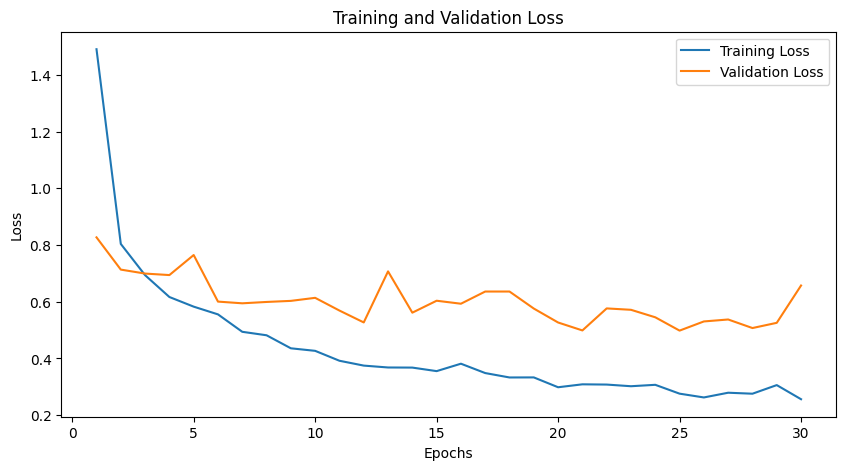

In [20]:
#loss 繪製
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

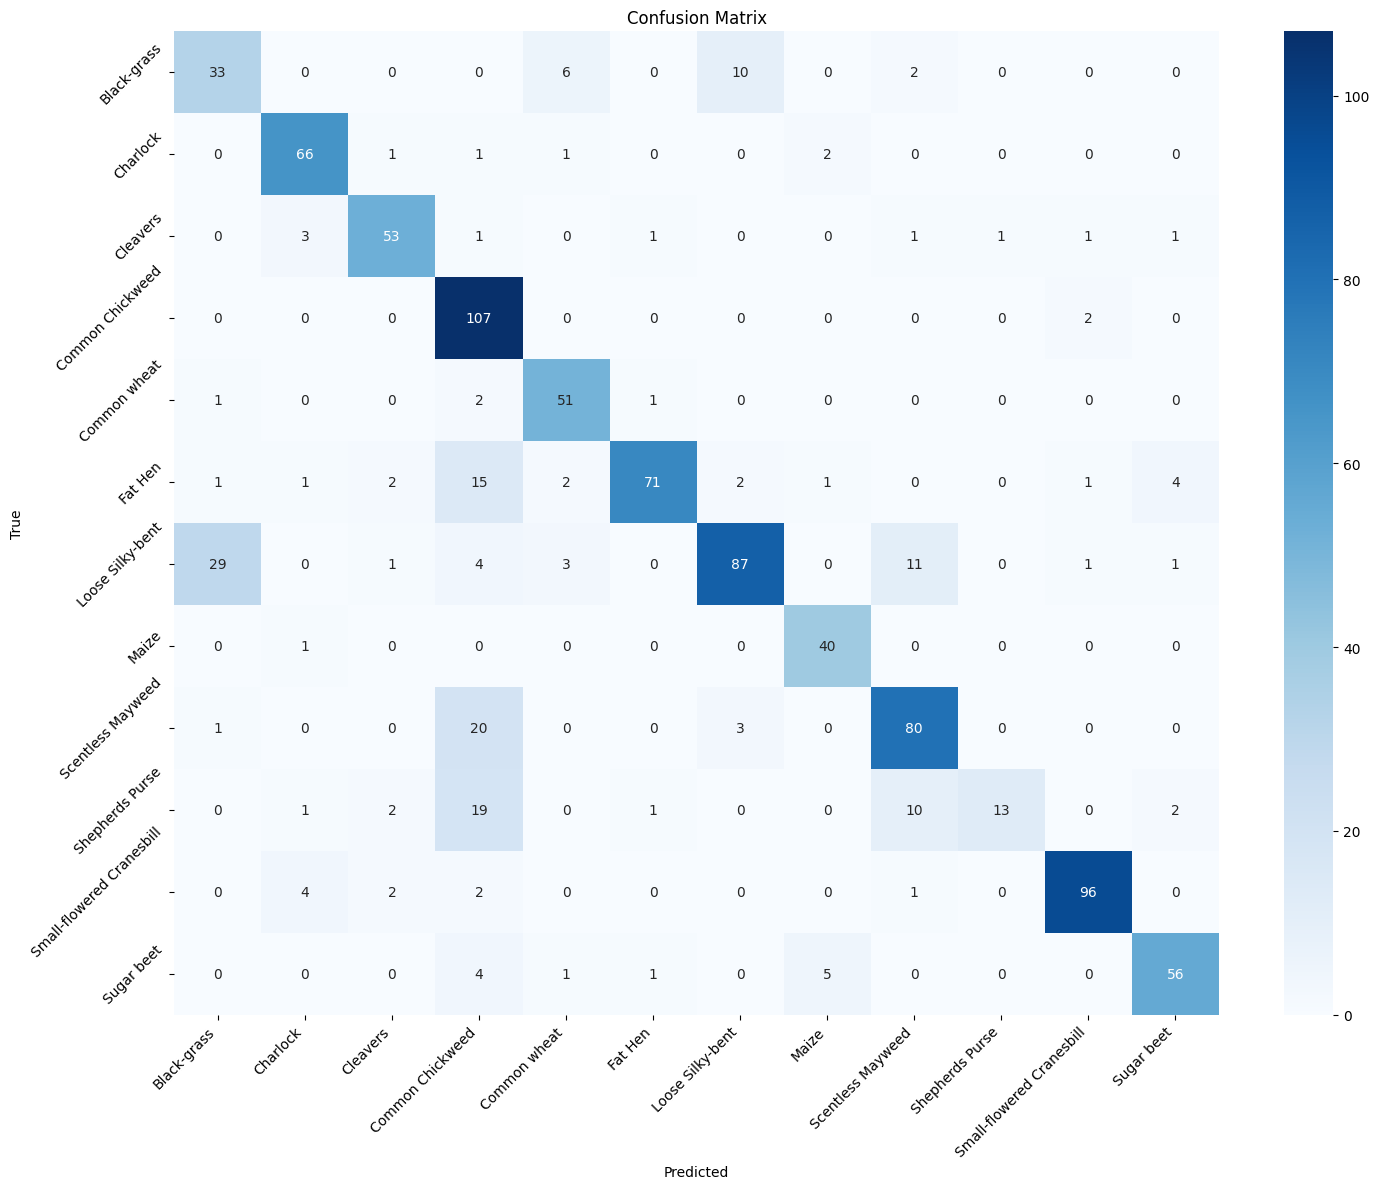

Black-grass: 0.65
Charlock: 0.93
Cleavers: 0.85
Common Chickweed: 0.98
Common wheat: 0.93
Fat Hen: 0.71
Loose Silky-bent: 0.64
Maize: 0.98
Scentless Mayweed: 0.77
Shepherds Purse: 0.27
Small-flowered Cranesbill: 0.91
Sugar beet: 0.84
Overall Accuracy: 0.79


In [21]:
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    return torch.cat(all_preds), torch.cat(all_labels)

# 如果GPU內存不夠，切換到CPU
try:
    predictions, labels = get_all_preds(model, val_loader)
except RuntimeError:  #抓CUDA out of memory錯誤
    print("GPU記憶體不夠,移到CPU.")
    model = model.cpu()
    device = torch.device("cpu")
    predictions, labels = get_all_preds(model, val_loader)

predictions = torch.argmax(predictions, dim=1)
cm = confusion_matrix(labels, predictions)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 計算每個類別的準確率
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# 打印每個類別的準確率
for i, accuracy in enumerate(class_accuracy):
    print(f'{class_names[i]}: {accuracy:.2f}')

# 計算總體準確率
overall_accuracy = cm.diagonal().sum() / cm.sum()
print(f'Overall Accuracy: {overall_accuracy:.2f}')

In [22]:
#testing 結果

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

# 定義數據轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加載測試數據
test_dir = '/content/drive/MyDrive/Colab/MLB_HW1/test'  # 請確保這是您測試數據的正確路徑
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 檢查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 將模型移到設備上
model = model.to(device)

# 進行預測
predictions = []
file_names = []

model.eval()
with torch.no_grad():
    for inputs, names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        file_names.extend(names)

# 創建預測結果的數據框
results = pd.DataFrame({
    'file': file_names,
    'species': [class_names[pred] for pred in predictions]
})

# 保存預測結果
results.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

# 顯示前幾行預測結果
print(results.head())

Using device: cuda
Predictions saved to 'predictions.csv'
            file           species
0  172f9b10b.png  Common Chickweed
1  043449b0b.png        Sugar beet
2  0437393b1.png           Fat Hen
3  04814f36d.png  Common Chickweed
4  05341a8a6.png  Common Chickweed


In [24]:
#保存模型
torch.save(model.state_dict(), '/content/drive/MyDrive/plant_seedlings_model.pth')
print("模型已保存")

模型已保存
